# Lyrics analysis
In this notebook, we analyse the lyrics of the songs in the extracted dataset. We pose and answer the following questions:
1. What is the genre distribution?
2. What are the sentiments attributed by the lyrics in a scale from -1 to +1? 
3. What is the lyricity in each genre (i.e. number of unique words, main verbs and nouns)?
4. What are the emotions in each genre?

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from nltk.corpus import words
from collections import Counter
from tqdm import tqdm

In [3]:
songs = pd.read_json('data/all_genres_en.json')
print(songs.shape)
songs.head()

(29617, 9)


,name,author,link,lyrics,chords,genre,actual_name,language,clean_lyrics
0,As Long As The Grass Shall Grow,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"As long, As the moon shall rise, As ...","['A', 'E', 'A', 'A', 'E', 'A', 'D', 'D', 'A', ...",Country,As Long As The Grass Shall Grow,en,"As long, As the moon shall rise, As ..."
1,Delias Gone (ver 4),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"Delia, oh, Delia Delia all my life\r\nIf I had...","['A', 'D', 'A', 'A7', 'D', 'B7', 'E', 'A', 'D'...",Country,Delias Gone,en,"Delia, oh, Delia Delia all my life If I hadn't..."
2,Mean Eyed Cat,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,I gave my woman half my money at the general s...,"['E', 'B7', 'E', 'A7', 'B7', 'E', 'E', 'B7', '...",Country,Mean Eyed Cat,en,I gave my woman half my money at the general s...
3,I Couldnt Keep From Crying,Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,"I SAW YOU WALKING BY HIS SIDE,\r\nHEARD YOU W...","['A', 'A7', 'D', 'A', 'E7', 'A', 'A7', 'D', 'A...",Country,I Couldnt Keep From Crying,en,"I SAW YOU WALKING BY HIS SIDE, HEARD YOU WHIS..."
4,It Aint Me Babe (ver 3),Johnny Cash,https://tabs.ultimate-guitar.com/tab/johnny-ca...,Go 'way from my window leave at your own chose...,"['A', 'Bm', 'A', 'E', 'A', 'A', 'Bm', 'A', 'E'...",Country,It Aint Me Babe,en,Go 'way from my window leave at your own chose...


**ABOUT THE DATASET**: 29.6 thousand songs. Contains columns as: name, author, link, lyrics, chords, genre, and language (only English songs are kept).

### Q1: What is the genre distribution?

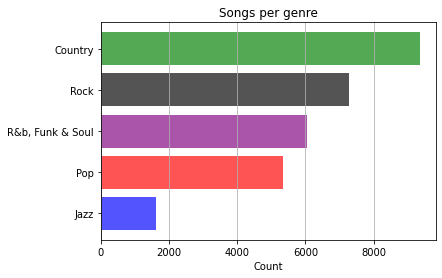

In [3]:
songs['genre'].value_counts().values

plt.barh(songs['genre'].value_counts().keys()[::-1], songs['genre'].value_counts().values[::-1], color=['blue', 'red', 'purple', 'black', 'green'], alpha=0.67)
plt.grid(axis='x')
plt.title('Songs per genre')
plt.xlabel('Count')
plt.rcParams['font.size'] = '13'

**CONCLUSION**: See the plot above!

### Q2: What are the sentiments attributed by the lyrics in a scale from -1 to +1? 
Here, -1 means most negative polarity, and +1 most positive.

In [7]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer() # initialize the Vader sentiment analyzer

tqdm.pandas()

def get_sentiment(compound, threshold=0.3):
    """Compound is a value between -1 and 1."""
    if compound > threshold:
        return 'positive'
    elif compound < -threshold:
        return 'negative'
    elif -threshold < compound < threshold:
        return 'neutral'
    raise ValueError

songs['sentiment'] = songs['clean_lyrics'].progress_apply(lambda lyrics: analyzer.polarity_scores(lyrics))
songs['sentiment_name'] = songs['sentiment'].apply(lambda sentiment: get_sentiment(sentiment['compound']))
songs['sentiment_compound'] = songs['sentiment'].apply(lambda dict: dict['compound'])

# songs.to_json('data/songs_with_sentiment.json.bz2', compression='bz2')

100%|██████████| 29617/29617 [01:37<00:00, 302.97it/s]


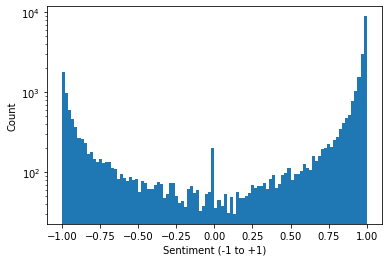

In [19]:
_ = plt.hist(songs['sentiment_compound'], bins=100)
_ = plt.xlabel('Sentiment (-1 to +1)')
_ = plt.ylabel('Count')
_ = plt.yscale('log')

In [17]:
print(f"Number of positive songs (more than 0.3 compound): {songs.sentiment_name.value_counts()['positive']}")
print(f"Number of negative songs (less than -0.3 compound): {songs.sentiment_name.value_counts()['negative']}")
print(f"Number of neutral songs (between -0.3 and 0.3 compound): {songs.sentiment_name.value_counts()['neutral']}")

Number of positive songs (more than 0.3 compound): 20379
Number of negative songs (less than -0.3 compound): 7558
Number of neutral songs (between -0.3 and 0.3 compound): 1680


**CONCLUSION**: See the plot of sentiment distribution above (log-scale), as well as the prints just above. Notice there are almost three times more "positive" songs than "negative" ones.

### Q3: What is the lyricity in each genre (i.e. number of unique words, main verbs and nouns)?
See below!

### Q4: What are the emotions in each genre?
See below!

Tokenization + lemmatization

In [20]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

nlp = spacy.load('en_core_web_sm')
nlp.remove_pipe('ner')
nlp.remove_pipe('senter')

stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [21]:
lyrics_per_genre = {}
for genre in songs.genre.value_counts().keys():
    lyrics_per_genre[genre] = ' '.join(songs[songs.genre == genre]['lyrics']).lower().replace('-', '')

In [30]:
class Genre:
    def __init__(self, name):
        
        corpus = set(words.words())
        nlp.max_length = 11_000_000

        self.name = name
        print(f'---> Creating spacy document for genre: {name}.')
        self.doc = nlp(lyrics_per_genre[name][0:200_000])
        self.nouns = [token.lemma_ for token in self.doc if token.pos_ == 'NOUN' and token.is_stop == False and token.is_punct == False and token.text in corpus]
        self.verbs = [token.lemma_ for token in self.doc if token.pos_ == 'VERB' and token.is_stop == False and token.is_punct == False and token.text in corpus]
        self.pronouns = [token.lemma_ for token in self.doc if token.pos_ == 'PRON' and token.is_stop == False and token.is_punct == False and token.text in corpus]
        self.nouns_freq = Counter(self.nouns)
        self.verbs_freq = Counter(self.verbs)
        self.pronouns_freq = Counter(self.pronouns)

        nr = 7

        print(f'NOUNS: {self.nouns_freq.most_common(nr)}')
        print(f'VERBS: {self.verbs_freq.most_common(nr)}')
        print(f'PRONOUNS: {self.pronouns_freq.most_common(nr)}')

        self.unique_nouns = self.get_unique_nouns()
        print(f'Number of unique nouns: {len(self.unique_nouns)}.')

        a = Counter(sum([emotion for emotion in songs.loc[songs['genre'] == name]['emotion']], []))

        self.primary_emotions = {k: v / total for total in (sum(a.values()),) for k, v in a.items()}
        self.primary_emotions['genre'] = name

    
    def get_unique_nouns(self):
        corpus = set(words.words())
        filtered_set = set()
        for word in np.unique(self.nouns):
            if word in corpus:
                filtered_set.add(word)
        return filtered_set
        

In [27]:
from transformers import pipeline
from timeit import default_timer as timer
from tqdm import tqdm

# --- We ran these commands below once before, it took 13 hours, and then we saved it in the songs_with_emotion.json.bz2 dataframe
# tqdm.pandas()
# task = 'zero-shot-classification'
# model = 'typeform/distilbert-base-uncased-mnli' # see there: https://huggingface.co/typeform/distilbert-base-uncased-mnli
# classifier = pipeline(task, model)
# labels = ['joy', 'sad', 'anger', 'fear', 'neutral', 'calm'] # Emotions taken from the Russel model of emotions
# m = len(labels)
# songs['emotion'] = songs['clean_lyrics'].progress_map(lambda lyrics: classifier(lyrics, labels)['labels'][0:3])
# ---------------------

songs = pd.read_json('data/songs_with_emotion.json.bz2', compression='bz2')

Study of primary emotions through genres

In [31]:
jazz = Genre('Jazz')
pop = Genre('Pop')
rb_funk_soul = Genre('R&b, Funk & Soul')
rock = Genre('Rock')
country = Genre('Country')

---> Creating spacy document for genre: Jazz.
NOUNS: [('love', 268), ('day', 149), ('time', 148), ('baby', 123), ('heart', 96), ('way', 96), ('night', 93)]
VERBS: [('know', 214), ('love', 201), ('go', 177), ('come', 161), ('get', 156), ('let', 148), ('tell', 122)]
PRONOUNS: [('somebody', 35), ('everybody', 16), ('ya', 6), ('s', 1), ('oho', 1), ('thee', 1)]
Number of unique nouns: 968.
---> Creating spacy document for genre: Pop.
NOUNS: [('love', 218), ('time', 151), ('heart', 147), ('baby', 118), ('way', 114), ('life', 93), ('night', 76)]
VERBS: [('know', 306), ('go', 159), ('get', 154), ('come', 131), ('let', 125), ('feel', 125), ('love', 122)]
PRONOUNS: [('everybody', 19), ('ya', 5), ('anybody', 5), ('d', 3), ('somebody', 2)]
Number of unique nouns: 835.
---> Creating spacy document for genre: R&b, Funk & Soul.
NOUNS: [('love', 250), ('baby', 244), ('time', 169), ('day', 102), ('heart', 101), ('night', 101), ('way', 99)]
VERBS: [('know', 302), ('go', 252), ('love', 209), ('get', 204)

**CONCLUSION (Q3)**: From this massive print above we can see the following patterns when it comes to the liricity of the genres:
- R&b, Funk and Soul is the music genre with the least number of unique words with 758 words, while Country is the one with most unique words used with 1074.
- The word 'love' is the most present word through all styles!
- The word 'baby' is in the top 10 of most used nouns in all styles byt in Country.
- The pronouns look odd ('la', 'y', 'oka', 's'), so the model doesn't seem to have worked there.
- The verbs through all genres all pretty much all similar and don't convey much interesting information.

**CONCLUSION (Q4)**: See below the emotions of all genres. Getting the maximum value per column we see:
- Jazz has the maximum emotions of calmness and joy;
- Country has the maximum emotion of sadness and neutrality;
- Rock has the maximum emotions of fear and anger.

In [32]:
emotions_df = pd.DataFrame(jazz.primary_emotions, index=[0])
emotions_df = emotions_df.append(rock.primary_emotions, ignore_index=True)
emotions_df = emotions_df.append(pop.primary_emotions, ignore_index=True)
emotions_df = emotions_df.append(rb_funk_soul.primary_emotions, ignore_index=True)
emotions_df = emotions_df.append(country.primary_emotions, ignore_index=True)
emotions_df

,neutral,calm,sad,joy,fear,anger,genre
0,0.249482,0.279296,0.156936,0.142650,0.097101,0.074534,Jazz
1,0.246560,0.255274,0.166988,0.110209,0.123372,0.097597,Rock
2,0.245109,0.265607,0.152648,0.128847,0.121308,0.086480,Pop
3,0.240121,0.259327,0.156402,0.132781,0.118433,0.092936,"R&b, Funk & Soul"
4,0.258352,0.269833,0.169822,0.120120,0.096873,0.085000,Country
